## Imports

In [1]:
import os
import json
import pandas as pd
from fnmatch import fnmatch
from pathlib import Path
from os.path import basename
from pprint import pprint

import matplotlib.pyplot as plt

## Load Evaluation Results

In [2]:
eval_results_datasets_dict = dict()
for dataset in os.listdir('../models_datasets'):
    eval_results_dataset_dict = dict()
    for root_dir, sub_dir, file_names in os.walk('../models_datasets/' + dataset):
        for file_name in file_names:
            if fnmatch(file_name, 'evaluation_results.json'):
                file_path = os.path.join(root_dir, file_name)
                model_name = basename(Path(file_path).parent).split('hold_all_')[-1]
                #print(model_name)

                with open(file_path, 'r') as fp:
                    eval_results = json.load(fp)
                    #pprint(eval_results)                
                    eval_results_dataset_dict[model_name] = eval_results
    eval_results_datasets_dict[dataset] = eval_results_dataset_dict

# eval_results_datasets_dict

In [3]:
no_of_items_to_recommend = 10

datasets_eval_results = []
for dataset in eval_results_datasets_dict:
    eval_results_dataset_dict = eval_results_datasets_dict[dataset]
    dataset_eval = dict()
    dataset_eval['dataset'] = dataset
    for model in eval_results_dataset_dict:
        #print(dataset)
        eval_metrics = eval_results_dataset_dict[model]['no_of_items_to_recommend'][str(no_of_items_to_recommend)]
        
        for eval_metric, score in eval_metrics.items():
            model_eval_metric = model + '_' + eval_metric
            # print(model_eval_metric, score)
            dataset_eval[model_eval_metric] = score
    datasets_eval_results.append(dataset_eval)
datasets_eval_results_df = pd.DataFrame(datasets_eval_results)
# datasets_eval_results_df

In [4]:
datasets_eval_results_df.sort_values('dataset', inplace=True)

## Plot Evaluation Results

In [10]:
def get_eval_results(metric):
    metric_cols = ['dataset']
    for col in datasets_eval_results_df.columns:
        if metric in col:
            metric_cols.append(col)
    return datasets_eval_results_df[metric_cols]

def plot_eval_results(metric):
    metric_df = get_eval_results(metric)
    for col in metric_df.columns:
        if col == 'dataset':
            continue
        model_name, metric = col.split('_avg_')
        plt.plot('dataset', col, data=metric_df, marker='o', label=model_name)
    plt.legend()  
    plt.xlabel('Datasets')
    plt.ylabel(metric)
    plt.show()

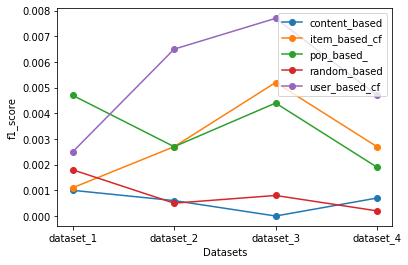

In [11]:
plot_eval_results('f1_score')

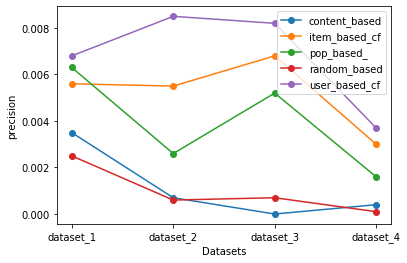

In [12]:
plot_eval_results('precision')

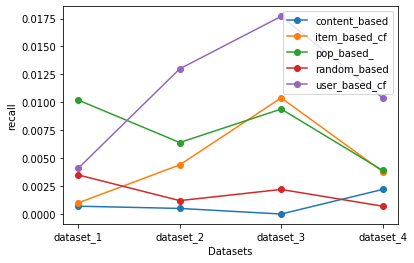

In [13]:
plot_eval_results('recall')

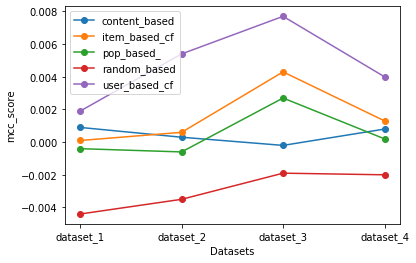

In [14]:
plot_eval_results('mcc')